# Student Feedback Analysis

### Importing libraries

In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')

### 1. Read the dataset

In [115]:
df = pd.read_csv('/content/Feedback.csv')
df.head()

,Review,Label
0,kind of boring,0.0
1,not bad,1.0
2,excellent,1.0
3,good communication,1.0
4,good explanation,1.0


### 2. Exploratory Data Analysis

#### 2.1 Count plot

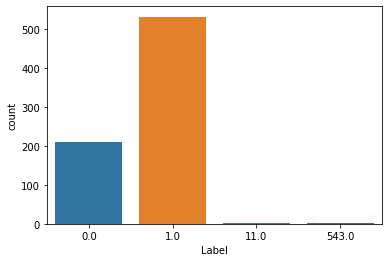

In [116]:
sns.countplot(df['Label'])

In [117]:
print('INFO: the number of positive feedback:',len(df[df['Label']==1]))
print('INFO: the number of negative feedback:',len(df[df['Label']==0]))

INFO: the number of positive feedback: 532
INFO: the number of negative feedback: 210


#### 2.2 Pie Chart

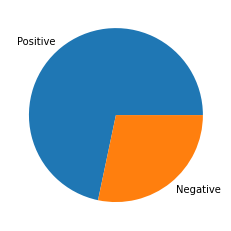

In [118]:
labels = ['Positive', 'Negative']
plt.pie([len(df[df['Label']==1]), len(df[df['Label']==0])], labels=labels)
plt.show()

#### Note:
- Since the number of positive feedback is more than negative feedback and the number of data is also less, our models may overfit and we can reduce it if we have balanced dataset

### 2.3 Remove Nan values

In [119]:
df.isna().sum()

Review    4
Label     4
dtype: int64

In [120]:
df[pd.isnull(df).any(axis=1)]

,Review,Label
571,content is sufficient for us,NaN
744,NaN,NaN
745,NaN,NaN
746,NaN,NaN
747,NaN,543.0


In [121]:
df.dropna(inplace=True)

In [122]:
df.isna().sum()

Review    0
Label     0
dtype: int64

### 3.Preprocessing
- lowercase the data
- remove extra whitespaces
- remove special characters (like punctuation, dollar symbol)
- remove numbers
- remove stopwords
- lemmatize


In [123]:
def preprocessing(text):
    text = text.lower()   #lowercase string
    text = text.strip()   #remove extra whitespaces
    text = re.sub(r'[^\w\s]', '', text) #remove punc
    text = re.sub(r'\d+', '', text)  #remove the numbers
    
    # remove stopwords
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]  
    
    #Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in filtered_sentence]
    return ' '.join(lemmas)

In [124]:
try:
  for idx in df.index:
    df['Review'][idx] = preprocessing(df['Review'][idx])
except:
  print(df['Review'][idx])

print('INFO: preprocessing Done')

INFO: preprocessing Done


### 4. Split the dataset

In [125]:
X = df['Review']
y = df['Label']

In [126]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=0)

In [127]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(497,)
(246,)
(497,)
(246,)


### 4. Word Embedding

In [128]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [129]:
print(X_train.shape)
print(X_test.shape)

(497, 460)
(246, 460)


In [130]:
import pickle
with open('vec.pkl', 'wb') as f:
  pickle.dump(vectorizer, f)

### 5. Modelling

In [131]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)
print('The training accuracy is:', clf.score(X_train, y_train))

The training accuracy is: 0.9557344064386318


### 6. Hyperparameter Tuning

In [132]:
from sklearn.model_selection import GridSearchCV
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
grid = dict(penalty=penalty,C=c_values)
grid_search = GridSearchCV(estimator=clf, param_grid=grid, n_jobs=-1, cv=10, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

In [133]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.830653 using {'C': 10, 'penalty': 'l2'}
0.818531 (0.061520) with: {'C': 100, 'penalty': 'l2'}
0.830653 (0.049027) with: {'C': 10, 'penalty': 'l2'}
0.812571 (0.048871) with: {'C': 1.0, 'penalty': 'l2'}
0.708245 (0.009828) with: {'C': 0.1, 'penalty': 'l2'}
0.710286 (0.008685) with: {'C': 0.01, 'penalty': 'l2'}


### Note: 
- From the hyperparameter tuning our best model is penalty 'l2' and C ='1.0'

### 7. Best Model

In [134]:
best_model = LogisticRegression(penalty='l2', C=1.0)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

In [135]:
with open('best_model_LR.pkl', 'wb') as f:
  pickle.dump(best_model, f)

### 8. Metrics
- Confusion Matrix

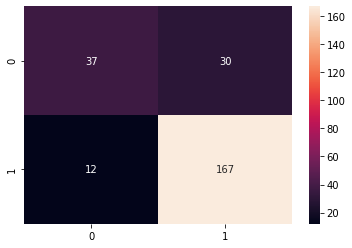

In [136]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.5g')

### Note:
- We can see that the number of positive result is correctly predicted for 167 data points and wrongly predicted for 12 data points
- Similarly , the model correctly predicted 37 data points as negative 30 times incorrectly predicted as negative

# Conclusion:
- We can improve the model by:
1. balancing the imbalanced dataset
2. Trying out different machine learning models
3. Other state of the art preprocessing
4. Other Word Embeddings like : GloVe, Word2vec methods
5. We can also use other metrics like Precision, Recall and F1 score for the metrics 

### Final Code

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')
import pickle
from sklearn.linear_model import LogisticRegression

#loading the best model
with open('best_model_LR.pkl', 'rb') as f:
  clf_LR = pickle.load(f)

#loading the vectorizer
with open('vec.pkl', 'rb') as f:
    vectorizer = pickle.load(f)

def preprocessing(text):
    text = text.lower()   #lowercase string
    text = text.strip()   #remove extra whitespaces
    text = re.sub(r'[^\w\s]', '', text) #remove punc
    text = re.sub(r'\d+', '', text)  #remove the numbers
    
    # remove stopwords
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]  
    
    #Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in filtered_sentence]
    return ' '.join(lemmas)

def vectorization(text):
  text = [text]
  X = vectorizer.transform(text)
  return X

def best_model(vector):
    result = clf_LR.predict(vector)
    return result

def prediction(text):
    text = preprocessing(text)
    X_vec = vectorization(text)
    pred = best_model(X_vec)
    return pred

# Predict with new data

In [139]:
prediction('The class is good')

array([1.])

In [140]:
prediction('Poor class')

array([0.])